# Machine Learning 0 - Introduction

In this lab, we will introduce the classification problem that we will be working on for the last three labs. The objectives of the lab are:

* Examine the dataset and prepare the basic pipeline that will be used in the next lab.
* Make sure that we use a correct methodology for comparing the algorithms
* Get used to working with the [scikit-learn](https://scikit-learn.org/stable/) library.

## Important note

For the machine learning labs, **each student must write a report** (one report for all labs together) which will be used during the oral exam. This report should highlight the different methods used during the labs, but also how you validated each method and compared their results.

## Introduction to the dataset

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has been collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60.000 32x32 colour images, split in 10 classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

*Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.* PDF available at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

For the purpose of the INFO-H-501 laboratories, we will use a subset of those images by only taking 3 different classes: 'airplane', 'bird' and 'horse'.

[Click here to download](https://my.pcloud.com/publink/show?code=XZJUCPkZqiVxqtn8CXRB7D78YKt88RJvzWyk) the modified dataset. Extract the ZIP file and put the CIFAR10 folder in the same directory as the notebook.

The images are 32x32 8-bit **RGB**, and from these we extracted **Histogram of Gradient** vectors (16 orientations x 16 blocks = 256 values in HoG vector).

The following code pre-loads all of this data (make sure that you have the [lab_tools.py](https://github.com/odebeir/info-h-500-501/blob/master/LABS1/lab_tools.py) file in the same directory as the notebook, if you didn't clone the repository):

In [10]:
from lab_tools import CIFAR10, get_hog_image

Pre-loading training data
Pre-loading test data


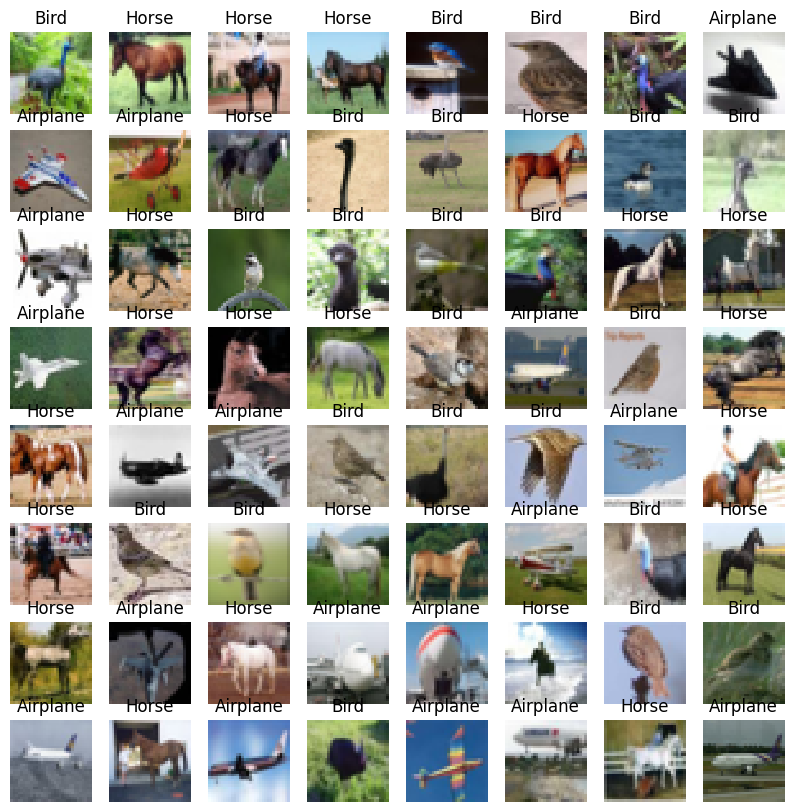

In [11]:
dataset = CIFAR10('./CIFAR10')
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(dataset.train['images'][i].reshape((32,32,3)), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

We can also have a look at some HoG images:

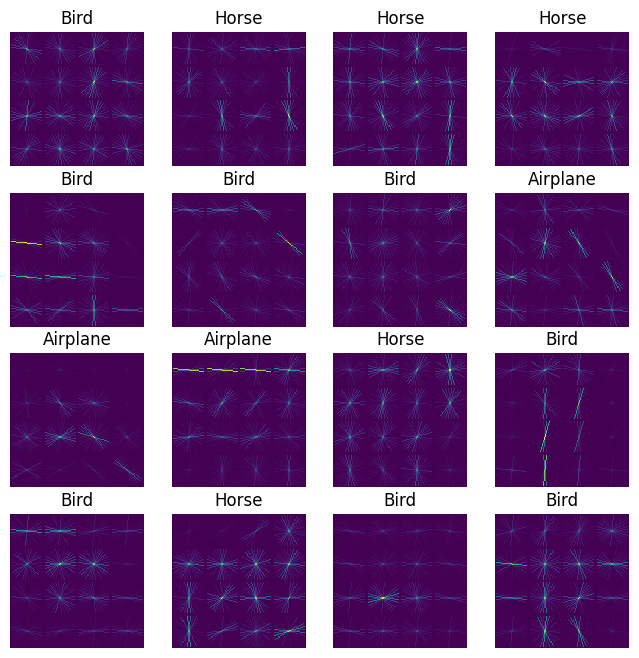

In [12]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    hog = dataset.train['hog'][i].reshape((4,4,16))
    plt.imshow(get_hog_image(hog, 128), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

Note that this is an "image" representation of the HoG, but that the actual data that we will be working on is a size 256 vector for each image. Our **feature space** has therefore 256 dimensions. 

## Exploring the dataset

The *dataset* object gives you access to different attributes:

* *dataset.path* contains the path to the CIFAR10 folder.
* *dataset.labels* contains the name of the three classes
* *dataset.train* and *dataset.test* are dictionaries containing three numpy arrays each:
    * *images* contains the RGB images
    * *hog* contains the HoG vectors
    * *labels* contains the label for each image

In [31]:
print(dataset.path)
print(dataset.labels)
print(dataset.train.keys())
print(dataset.train['hog'].shape)

./CIFAR10
['Airplane', 'Bird', 'Horse']
dict_keys(['images', 'hog', 'labels'])
(15000, 256)


### Quick questions:

The dataset has already been split into a training set (dataset.train) and a test set (dataset.test).

* How many images are in the training set ?
* How many images are in the test set ?
* What is the class distribution of the dataset ?

In [32]:
from lab_tools import CIFAR10
dataset = CIFAR10('./CIFAR10')

# Number of images in the training set
num_train_images = dataset.train['images'].shape[0]

# Number of images in the test set
num_test_images = dataset.test['images'].shape[0]

# Class distribution
class_distribution = {label: sum(dataset.train['labels'] == i) for i, label in enumerate(dataset.labels)}

print("Number of images in the training set:", num_train_images)
print("Number of images in the test set:", num_test_images)
print("Class distribution of the dataset:", class_distribution)

Pre-loading training data
Pre-loading test data
Number of images in the training set: 15000
Number of images in the test set: 3000
Class distribution of the dataset: {'Airplane': 5000, 'Bird': 5000, 'Horse': 5000}


### Descriptive data analysis

Look at the HoG data from the training set. What are the characteristics of the dataset ? Do you think that some pre-processing may be required to help with the different algorithms ?


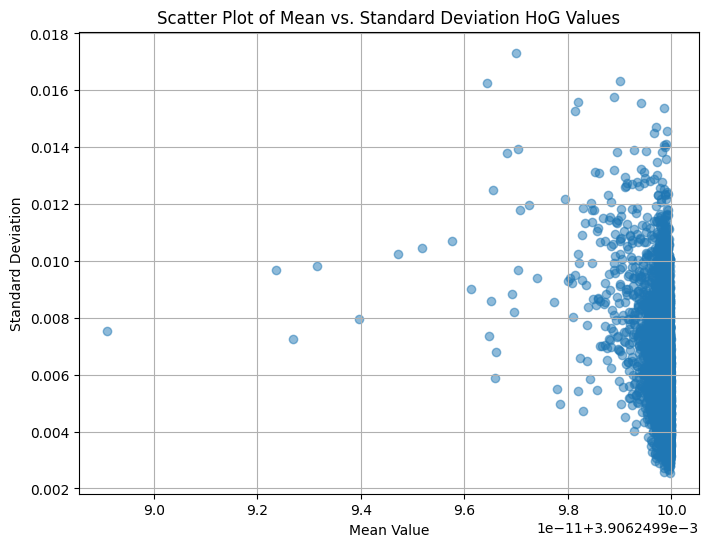

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# HoG data from the training set
hog_data = dataset.train['hog']

# Mean and standard deviation of HoG data
hog_mean = np.mean(hog_data, axis=1)
hog_std = np.std(hog_data, axis=1)

# Scatter plot of mean vs. standard deviation
plt.figure(figsize=(8, 6))
plt.scatter(hog_mean, hog_std, alpha=0.5)
plt.title('Scatter Plot of Mean vs. Standard Deviation HoG Values')
plt.xlabel('Mean Value')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()

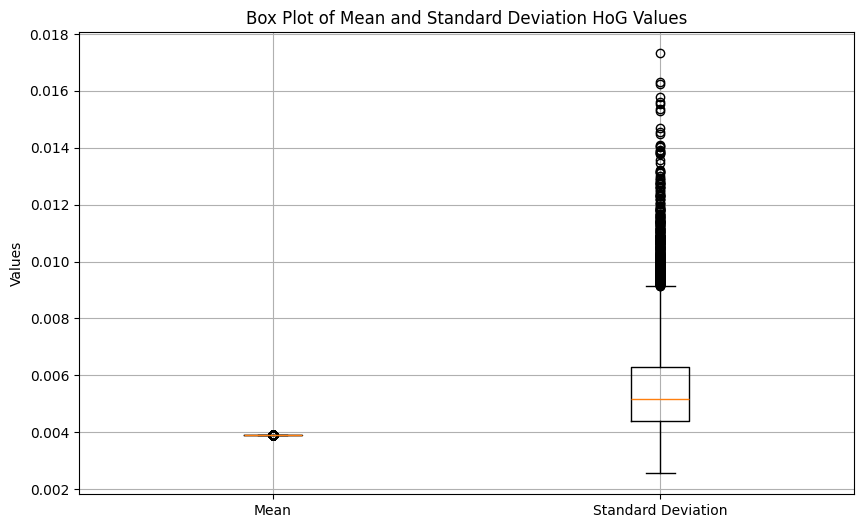

In [ ]:
# Create a box plot for mean and standard deviation
plt.figure(figsize=(10, 6))
plt.boxplot([hog_mean, hog_std], labels=['Mean', 'Standard Deviation'])
plt.title('Box Plot of Mean and Standard Deviation HoG Values')
plt.ylabel('Values')
plt.grid(True)
plt.show()

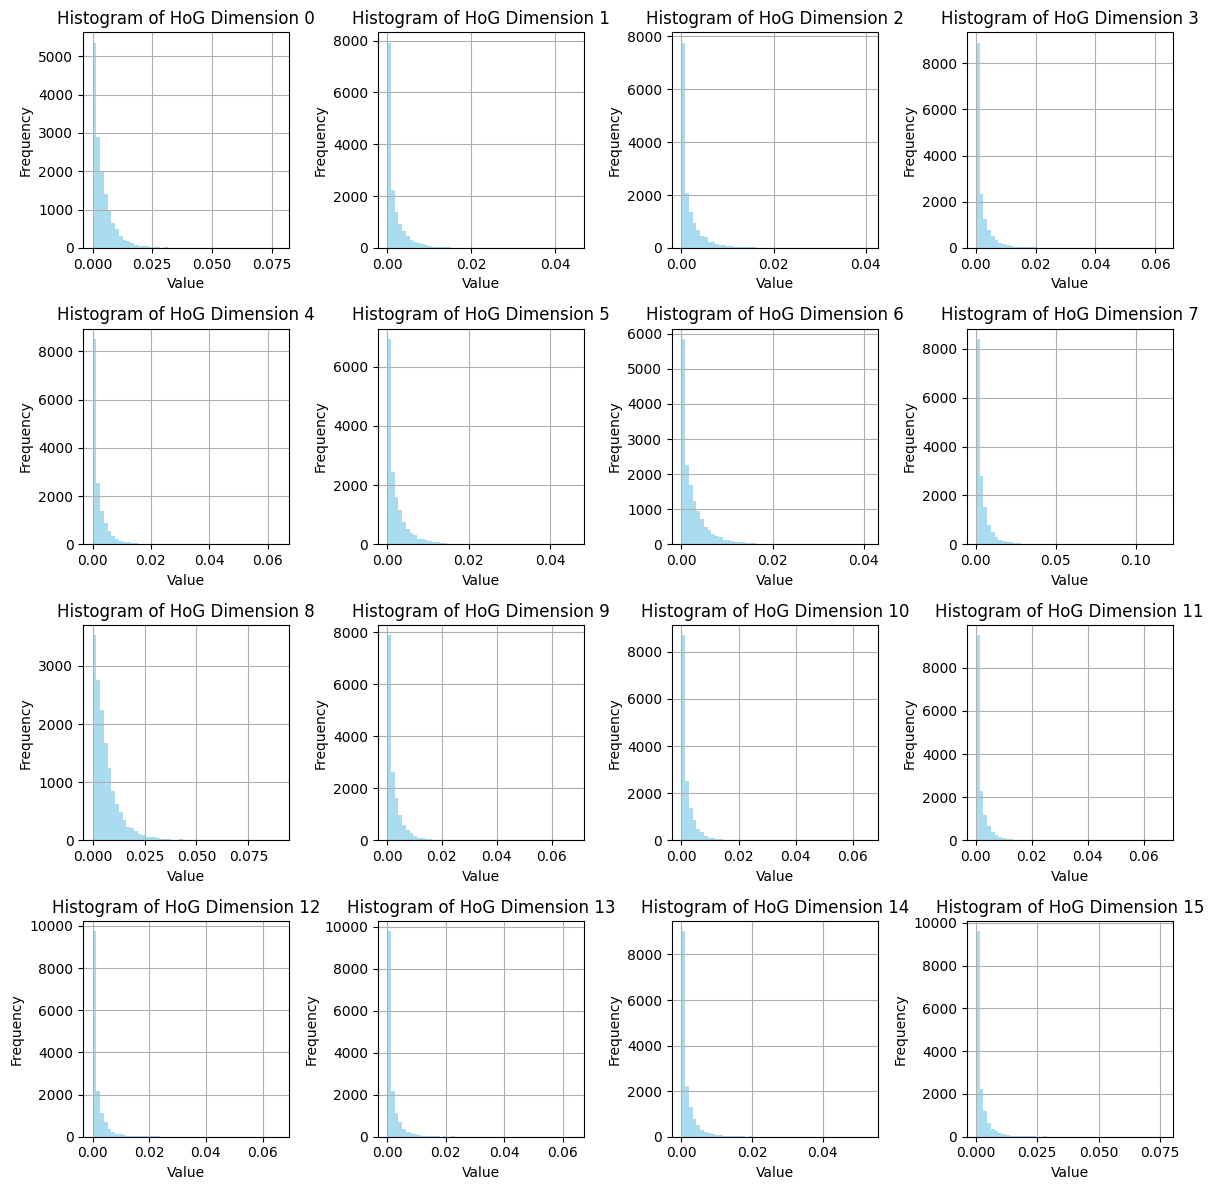

In [18]:
# Plot histograms for individual dimensions
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(16):
    ax = axs[i // 4, i % 4]
    ax.hist(hog_data[:, i], bins=50, color='skyblue', alpha=0.7)
    ax.set_title(f'Histogram of HoG Dimension {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

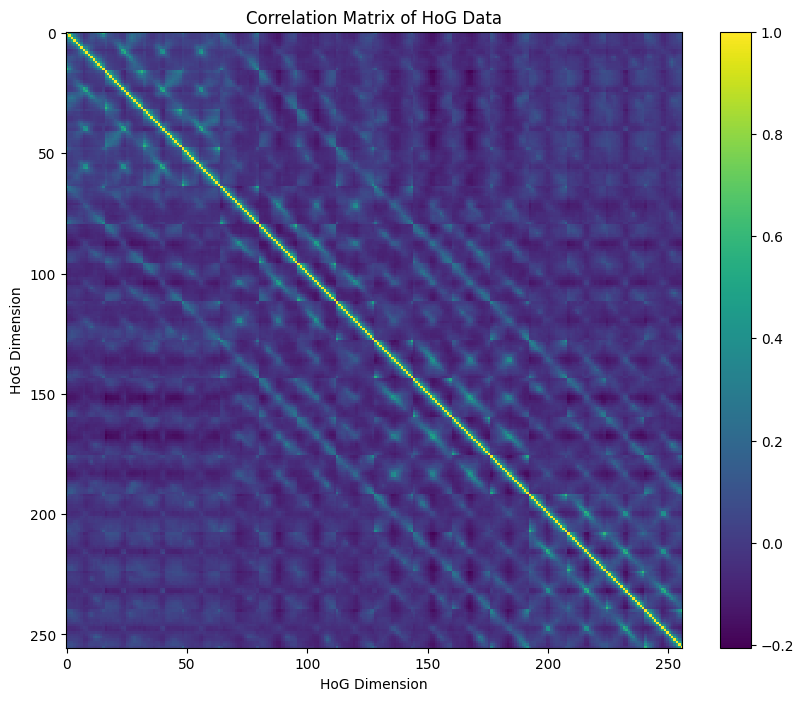

In [19]:
# Compute correlation matrix
correlation_matrix = np.corrcoef(hog_data, rowvar=False)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix of HoG Data')
plt.xlabel('HoG Dimension')
plt.ylabel('HoG Dimension')
plt.show()

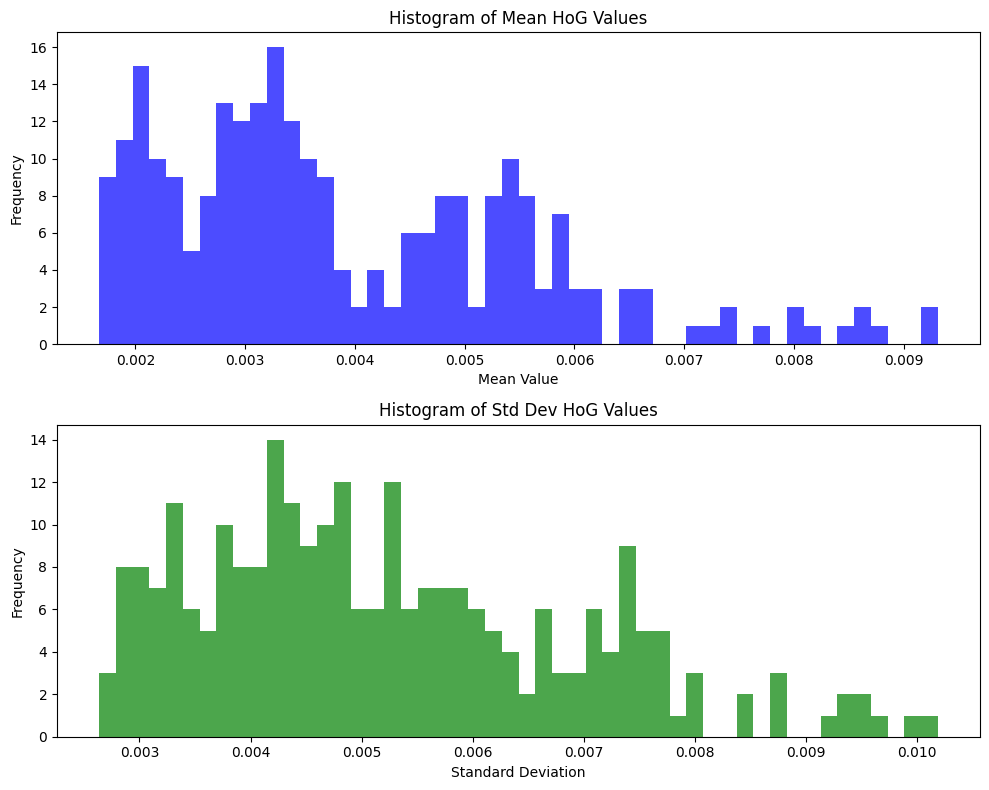

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# HoG data from the training set
hog_data = dataset.train['hog']

# Mean and standard deviation of HoG data
hog_mean = np.mean(hog_data, axis=0)
hog_std = np.std(hog_data, axis=0)

# Create histograms
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Histogram of mean values
axs[0].hist(hog_mean, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Mean HoG Values')
axs[0].set_xlabel('Mean Value')
axs[0].set_ylabel('Frequency')

# Histogram of standard deviation values
axs[1].hist(hog_std, bins=50, color='green', alpha=0.7)
axs[1].set_title('Histogram of Std Dev HoG Values')
axs[1].set_xlabel('Standard Deviation')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Introduction to scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/) is a very well documented machine learning library in Python. It contains many algorithms for [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), and makes the whole process of building a machine learning pipeline relatively straightforward. There are many examples in the documentation, as well as relatively complete theoretical explanations, so I really encourage you to take the time to read it if some things are not clear.

Let's make a very simple example. We are going to use the [Ridge Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), which is a very basic linear model.

In [21]:
from sklearn.linear_model import RidgeClassifier

To use a classifier with scikit-image, we generally have three steps:

* Create an instance of the class of the classifier (here: RidgeClassifier). The constructor will generally contain many arguments that can be modified, and that are explained in the documentation. There will also generally be default values for all of them, so in this simple example we will just use those:

In [22]:
clf = RidgeClassifier()

* Use the *fit* method with, as arguments, the training data (in our case, the HoG vectors) and the corresponding labels. This will start the main training algorithm, trying to fit the parameters of the classifier with the training data:

In [23]:
clf.fit(dataset.train['hog'], dataset.train['labels'])

RidgeClassifier()

* Use the *predict* method to get the prediction of the classifier on the data given as argument. In this case, we get the predictions on the data that was just used for training. **What kind of performance will that give us?**

In [24]:
pred = clf.predict(dataset.train['hog'])
print(pred.shape)

(15000,)


We can then evaluate those predictions. Scikit-learn provides many different [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluating the performances of a classifier. The most simple of those is the accuracy, which is simply the number of correct predictions divided by the total number of predictions:

In [25]:
from sklearn.metrics import accuracy_score

score = accuracy_score(dataset.train['labels'], pred)
print(score)

# Not that it's fairly easy to compute that score "by hand":
T = (pred==dataset.train['labels']).sum()
print(T, len(pred), T/len(pred))

0.7356666666666667
11035 15000 0.7356666666666667


In a multiclass problem, it's often also very useful to look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), which gives us more information on which classes are often mistaken for each other:

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(dataset.train['labels'], pred)
print(cm)


[[3812  740  448]
 [ 742 3236 1022]
 [ 337  676 3987]]


Note that the rows represent the **true labels** and the columns the **predicted labels**. So this mean that, in this case, out of the 5000 images of class 0 ("Airplane"), 3812 were correctly classified, 740 were classified as "Bird" and 448 as "Horse").

### Quick question

* Modify the code to estimate the **predictive** performance of the algorithm (without using the test set).

In [27]:
from sklearn.model_selection import train_test_split
#Modify the code to estimate the **predictive** performance of the algorithm (without using the test set)
#by using a portion of the training set as a validation set.
#Hint: you can use the `train_test_split` function from scikit-learn to split the training set into two parts.
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataset.train['hog'], dataset.train['labels'], test_size=0.2, random_state=42)

# Create an instance of the classifier
clf = RidgeClassifier()

# Fit the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the validation set
pred_val = clf.predict(X_val)

# Evaluate the predictive performance on the validation set
score_val = accuracy_score(y_val, pred_val)
print("Predictive performance on the validation set:", score_val)



Predictive performance on the validation set: 0.7343333333333333


## How can we find the "best" algorithm?

What we have shown above served to illustrate how scikit-learn classifiers work, but we now have to build a valid machine learning pipeline to compare the different algorithms that we will use in the next labs.

As we have said earlier, we have already split the dataset into a "training" and a "test" set. It is clear that the final evaluation should take place on the test set.

But in addition to comparing the algorithms between each other, we also have to find the best "hyper-parameters" for each algorithm. For example, in our RidgeClassifier example, there is a regularization parameters, *alpha*, which by default was set to 1.0. Can we improve the performance of the algorithm by modifying this parameter ?

### Side-note: parameter vs hyper-parameter

In general, when talking about machine learning models, **parameters** are what the algorithm learns with the data (if we are for instance learning a linear regression y = ax+b, the "parameters" would be a and b), while **hyper-parameters** are modifiers to the model or to the pipeline (for instance, if we are generalizing to a polynomial regression, the degree of the polynome would be an hyper-parameter).

### Cross-validation

The most common way of finding the best hyper-parameters of a classifier is to use [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

* Using the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) method from scikit-learn, find the best *alpha* hyper-parameter for the RidgeClassifier: 

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [0.1, 1.0, 10.0]}

# Create an instance of the classifier
clf = RidgeClassifier()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the GridSearchCV instance on the training data
grid_search.fit(X_train, y_train)

# Get the best hyper-parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

print("Best hyper-parameters:", best_params)
print("Best score:", best_score)


Best hyper-parameters: {'alpha': 0.1}
Best score: 0.7434999999999999


In [29]:
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

# Define the alpha values to try
alphas = [0.1, 1.0, 10.0]

# Create an instance of the classifier
clf = RidgeClassifier()

# Dictionary to store mean cross-validated scores
mean_scores = {}

# Loop through alpha values and calculate mean cross-validated score
for alpha in alphas:
    clf.alpha = alpha
    scores = cross_val_score(clf, dataset.train['hog'], dataset.train['labels'], cv=5)
    mean_score = np.mean(scores)
    mean_scores[alpha] = mean_score

# Get the best alpha
best_alpha = max(mean_scores, key=mean_scores.get)

# Create an instance of the classifier with the best alpha
best_clf = RidgeClassifier(alpha=best_alpha)

# Fit the best classifier on the training data
best_clf.fit(dataset.train['hog'], dataset.train['labels'])

# Get the best score
best_score = mean_scores[best_alpha]

print("Best alpha:", best_alpha)
print("Best score:", best_score)


Best alpha: 0.1
Best score: 0.7442666666666666


### Comparing algorithms

Once you have found the best hyper-parameters for an algorithm, you can re-train the classifier on the whole training set, and finally use the test set to get a "final performance". 

* How can you then decide which of the classifiers is best ?
* How can you decide if the different between two classifiers is significant ?

Try to compare the best RidgeClassifier with the original. Is it significantly better?

In [30]:
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from scipy import stats

# Define the best hyper-parameter
best_alpha = 1.0  # Assuming this is the best alpha from previous steps

# Create the best classifier with the best hyper-parameter
best_clf = RidgeClassifier(alpha=best_alpha)

# Fit the best classifier on the entire training set
best_clf.fit(dataset.train['hog'], dataset.train['labels'])

# Predict on the test set with the best classifier
pred_test_best = best_clf.predict(dataset.test['hog'])

# Calculate accuracy of the best classifier
accuracy_test_best = accuracy_score(dataset.test['labels'], pred_test_best)

# Now, let's calculate accuracy for the original classifier without the best hyperparameters
clf = RidgeClassifier()  # Original classifier without best hyperparameters

# Fit the original classifier on the entire training set
clf.fit(dataset.train['hog'], dataset.train['labels'])

# Predict on the test set with the original classifier
pred_test_original = clf.predict(dataset.test['hog'])

# Calculate accuracy of the original classifier
accuracy_test_original = accuracy_score(dataset.test['labels'], pred_test_original)

print("Accuracy of Best Classifier on Test Set:", accuracy_test_best)
print("Accuracy of Original Classifier on Test Set:", accuracy_test_original)

# Perform paired t-test
t_stat, p_value = stats.ttest_rel([accuracy_test_best], [accuracy_test_original])

alpha = 0.05  # significance level

if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

# Calculate effect size (Cohen's d)
mean_diff = accuracy_test_best - accuracy_test_original
std_dev_diff = np.std([accuracy_test_best, accuracy_test_original])
if std_dev_diff == 0:
    effect_size = 0  # Handle the case of division by zero
else:
    effect_size = mean_diff / std_dev_diff

print("Effect Size (Cohen's d):", effect_size)

Accuracy of Best Classifier on Test Set: 0.729
Accuracy of Original Classifier on Test Set: 0.729
The difference is not statistically significant.
Effect Size (Cohen's d): 0


C:\Users\obave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\obave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1081: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
